<!--BOOK_INFORMATION-->
<img style="float: right; width: 100px" src="https://raw.github.com/pyomeca/design/master/logo/logo_cropped.svg?sanitize=true">

<font size="+2">Pyosim in the cloud</font>

<font size="+1">with [pyomeca](https://github.com/pyomeca/pyom</font>a)

Romain Martinez (martinez.staps@gmail.com | [GitHub](https://github.com/romainmartinez))


<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >

# Kinematics variability

In [1]:
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import altair as alt
from pyosim import Conf
from pyomeca import Analogs3d
import spm1d
import matplotlib.pyplot as plt

from src.util import (
    parse_conditions,
    condition_counter,
    random_balanced_design,
    get_spm_cluster,
    ridge_plot,
    describe_clusters,
)

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
alt.data_transformers.enable("json")
# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
aws_conf = yaml.safe_load(open("../conf.yml"))

conf = Conf(project_path=aws_conf["path"]["project"]["local"])
conf.check_confs()

Project loaded
Configuration file loaded


## Reading files

In [4]:
suffix = ""

kin = (
    pd.concat(
        [
            Analogs3d.from_sto(ifile)
            .time_normalization()
            .to_dataframe()
            .assign(filename=ifile.stem)
            for ifile in conf.project_path.glob(f"*/2_inverse_dynamic/*.sto")
        ]
    )
    .pipe(parse_conditions, suffix="wu_", prefix=suffix)
    .reset_index()
    .assign(index=lambda x: x["index"] / 100)
    .query("mass != 18 & height == 2")
)

kin.head()

,index,thorax_tilt_moment,thorax_list_moment,thorax_rotation_moment,thorax_tx_force,thorax_ty_force,thorax_tz_force,box_rotX_moment,box_rotY_moment,box_rotZ_moment,...,elbow_flexion_moment,pro_sup_moment,hand_r_Add_moment,hand_r_Flex_moment,filename,participant,men,height,mass,n_trial
101,0.00,7.449919,-12.017170,-0.409545,0.254581,233.261989,2.144789,0.000000,0.000000e+00,0.000000,...,1.722348,0.050725,0.061872,-0.264751,CamBF6H2_1,camb,0,2,6,1
102,0.01,9.791712,-13.028653,-1.435676,-6.909239,235.801182,7.671516,0.000043,-1.942890e-05,-0.000033,...,1.900383,0.240947,0.111326,-0.298590,CamBF6H2_1,camb,0,2,6,1
103,0.02,10.055537,-11.154893,-2.009678,-4.840682,236.902413,13.315561,-0.000024,6.716200e-06,0.000008,...,2.164831,0.531914,0.087649,-0.389567,CamBF6H2_1,camb,0,2,6,1
104,0.03,10.758266,-7.961517,-2.373552,-1.727230,242.003493,15.856095,-0.000020,-8.490000e-07,0.000045,...,2.660041,1.041233,0.014597,-0.562963,CamBF6H2_1,camb,0,2,6,1
105,0.04,15.107797,-4.962267,-4.273886,4.669713,245.803917,15.682532,0.000075,-2.693480e-05,-0.000093,...,2.622905,1.532940,-0.142399,-0.854626,CamBF6H2_1,camb,0,2,6,1


## Clean data

### Balance dataset

By randomly taking the minimum number of trials for each condition

In [5]:
to_bold = lambda x: "\033[1m" + x + "\033[0m"

print(to_bold("Initial"))
condition_counter(kin)

Initial
n. participants: 40
----------
men
0    111
1    123
----------
height
2    234
----------
mass
6     116
12    118
----------
men  mass
0    6       54
     12      57
1    6       62
     12      61
----------


In [6]:
balanced_trials = random_balanced_design(
    kin, ["men", "mass"], random_state=RANDOM_SEED
)["filename"].tolist()
kin = kin.query("filename == @balanced_trials")

print(to_bold("Balanced:"))
condition_counter(kin)

Balanced:
n. participants: 40
----------
men
0    108
1    108
----------
height
2    216
----------
mass
6     108
12    108
----------
men  mass
0    6       54
     12      54
1    6       54
     12      54
----------


### Drop unwanted variables

In [7]:
id_vars = ["filename", "participant", "men", "height", "mass", "n_trial", "index"]
kin_melt = kin.melt(id_vars=id_vars)
kin_melt.head()

,filename,participant,men,height,mass,n_trial,index,variable,value
0,CamBF6H2_1,camb,0,2,6,1,0.00,thorax_tilt_moment,7.449919
1,CamBF6H2_1,camb,0,2,6,1,0.01,thorax_tilt_moment,9.791712
2,CamBF6H2_1,camb,0,2,6,1,0.02,thorax_tilt_moment,10.055537
3,CamBF6H2_1,camb,0,2,6,1,0.03,thorax_tilt_moment,10.758266
4,CamBF6H2_1,camb,0,2,6,1,0.04,thorax_tilt_moment,15.107797


In [8]:
blacklist = [
    "thorax_tx",
    "thorax_ty",
    "thorax_tz",
    "box_rotX",
    "box_rotY",
    "box_rotZ",
    "box_transX",
    "box_transY",
    "box_transZ",
]

kin_melt = kin_melt.query("variable != @blacklist")

In [9]:
x = kin_melt.groupby(["variable", "mass", "men", "index"])["value"].std().reset_index()

In [18]:
y = (
    x.loc[x.variable.str.contains("moment")]
    .groupby(["men", "mass", "index"])["value"]
    .sum()
    .reset_index()
)
y.head(1)

,men,mass,index,value
0,0,6,0.0,41.063209


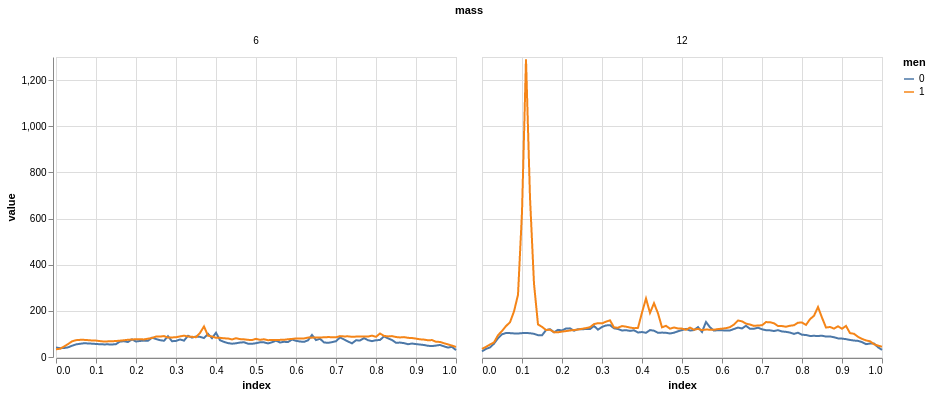

In [19]:
alt.Chart().mark_line().encode(
    alt.X("index"), alt.Y("value"), alt.Color("men:N")
).facet(data=y, column="mass")

<!--NAVIGATION-->
< [Analyses](02.00-men-women.ipynb) | [Contents](Index.ipynb) | [Joint reactions](02.02-joint-reactions.ipynb) >